# 1D DIffusion 

also the heat equation. Following [Dr. ZGan's Python CFD course notes](https://drzgan.github.io/Python_CFD/5.%201D%20diffusion%20equation.html).

some additional [notes](https://web.uvic.ca/~tbazett/diffyqs/classification_section.html) on the classification of diff eqs that may be useful

The 1D diffusion equation is:
\begin{split}
\frac{\partial u}{\partial t} = \nu \frac{\partial^2 u}{\partial x^2}
\end{split}

We discretize the second order derivative of $u$ w.r.t. $x$ using the second order centered difference:
\begin{split}
\frac{\partial^2 u}{\partial x^2} \approx \frac{u_{i+1}-2u_i+u_{i-1}}{\Delta x^2}
\end{split}

and discretize the first order derivative of $u$ w.r.t. $x$ using the first order forwards difference:
\begin{split}
\frac{\partial u}{\partial t} \approx \frac{u_i^{t+1} - u_i^t}{\Delta t}
\end{split}

Combining these discretizations, we arrive at the following (where we adopt an explicit timestep):
\begin{split}
\frac{u_i^{n+1} - u_i^n}{\Delta t} = \nu \frac{u_{i+1}^n-2u_i^n+u_{i-1}^n}{\Delta x^2}
\end{split}

Note that subscripts refer to spatial steps, and superscripts refer to time steps.

Rearranging to explicitly solve for $u_i^{n+1}$:
\begin{split}
u_i^{n+1} = u_i^n + \frac{\nu \Delta t}{\Delta x^2} (u_{i+1}^n-2u_i^n+u_{i-1}^n)
\end{split}

More information on stability for advection and diffusion can be found [here](https://math.mit.edu/~stoopn/18.086/Lecture7.pdf), but the key numbers are:

- CFL number (advection): $\frac{u \Delta t}{\Delta x} \leq C_{max}$. 
    - where $u$ is the velocity, $t$ is time, $x is spatial, and for explicit solvers $C_{max}$ is generally taken to be less than $1$. 

- Diffusion stability number: $\frac{\nu \Delta t}{\Delta x^2} \leq \frac{1}{2}$

In [36]:
import matplotlib.pyplot as plt
import numpy as np

Number of mesh points: 101
Mesh length: 2
Mesh size: 0.02
End time: 10
Time step: 0.01
Number of time steps: 1001
Diffusion stability number is: 0.25


Text(0, 0.5, 'Heat')

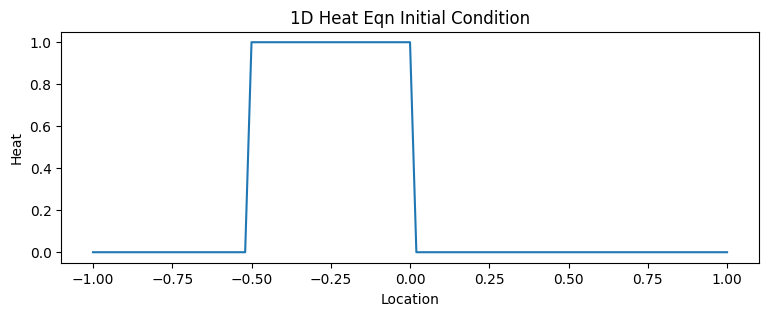

In [37]:
NX = 101  # number of grid points along X
X_start = -1
X_end = 1
LX = X_end - X_start
dX = LX / (NX - 1)  # spatial step size in X domain
nu = 0.01  # diffusion coefficient
dt = 0.01
T = 10
NT = int(T / dt) + 1

# print summary information
print("Number of mesh points:", NX)
print("Mesh length:", LX)
print("Mesh size:", dX)
print("End time:", T)
print("Time step:", dt)
print("Number of time steps:", NT)

# initialize mesh
mesh = np.linspace(X_start, X_end, NX)
tmesh = np.linspace(0, T, NT, endpoint=True)

# check stability number
diff_stab = nu * dt / (dX**2)
print("Diffusion stability number is:", diff_stab)
if diff_stab > 0.5:
    print("WARNING: DIFFUSION STABILITY NUMBER IS LARGER THAN 0.5")

# initialize field
# indexing convention is: (time, spatial)
u = np.zeros((NT, NX))

# set initial condition: for all spatial points, and for time = 0
# we'll set the points between 0.5 and 1
u[0, int(0.5/dX):int(1/dX+1)] = 1

# visualize initial condition
plt.figure(figsize=(9,3))
plt.plot(mesh, u[0, :])
plt.title("1D Heat Eqn Initial Condition")
plt.xlabel("Location")
plt.ylabel("Heat")

In [38]:
# Explicit time step solution loop
def solve(u):
    for n in range(NT - 1):
        # enforce Direchlet boundary condition by holding edge points at last known value
        u[n + 1, 0] = u[n, 0]
        u[n + 1, -1] = u[n, -1]
        # inner solution loop
        for i in range(1, NX - 1):
            u[n + 1, i] = u[n, i] + (nu * dt / (dX**2)) * (u[n, i + 1] - 2 * u[n, i] + u[n, i - 1])
    return u

u = solve(u)

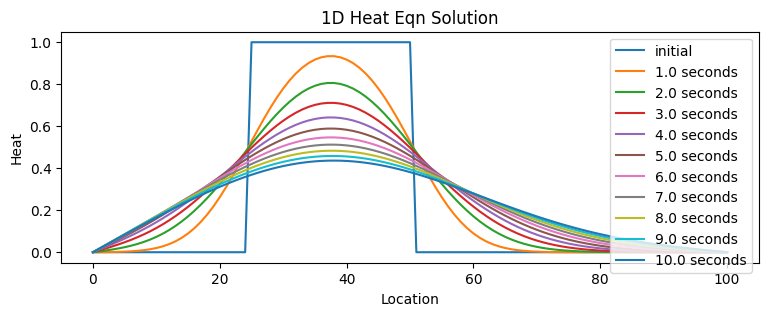

In [39]:
# visualize solution(s)
def visualize(u, dt:float=0.01, mesh=None):
    plt.figure(figsize=(9,3))
    if mesh is None:
        plt.plot(u[0, :], label="initial")
    else:
        plt.plot(mesh, u[0, :], label="initial")
    walk = int(1/dt)
    idx = walk
    while idx < u.shape[0]:
        if mesh is None:
            plt.plot(u[idx, :], label=f"{idx * dt} seconds")
        else:
            plt.plot(mesh, u[idx, :], label=f"{idx * dt} seconds")
        idx += walk
    plt.title(f"1D Heat Eqn Solution")
    plt.xlabel("Location")
    plt.ylabel("Heat")
    plt.legend()

visualize(u, dt=0.01)

Here we generate data for the purpose of operator learning the time evolving solution fields of a PDE given a spatial initial condition.

We will pick some random initial spatial conditions, consisting of positive spikes like above, negative spikes below, and random noise.

The data will be stored as values of $u(x)$ at ```(sample, time, x-location)```. There is no "channel" dimension as their is only one output field, which is the "heat" - the channel dimension is implied to be 1.

We will store both raw copies of the data, and ones with the timestep interpolated / downsampled.


In [40]:
# loop to generate solution trajectories

sol_list = []

for i in range(121):
    # generate initial conditoins from step responses
    # u = np.zeros((NT, NX))
    # start = int(np.random.rand() * NX)
    # end   = int(np.random.rand() * NX)
    # if start > end:
    #     start, end = end, start
    # u[0, start:end] = 1
    # generate initial conditions from chebyshev polynomials
    c = np.random.rand(5) * 2 - 1  # coefficients of polynomial, limited to between -1 and 1
    f = np.polynomial.chebyshev.chebval(mesh, c)  # evaluate polynomial
    u = np.zeros((NT, NX))
    u[0, :] = f
    u = solve(u)
    sol_list.append(u)

In [41]:
sols = np.stack(sol_list, axis=0)
sols.shape

(121, 1001, 101)

In [42]:
sols.max(), sols.min()

(np.float64(3.4632693090358866), np.float64(-3.1895604505132384))

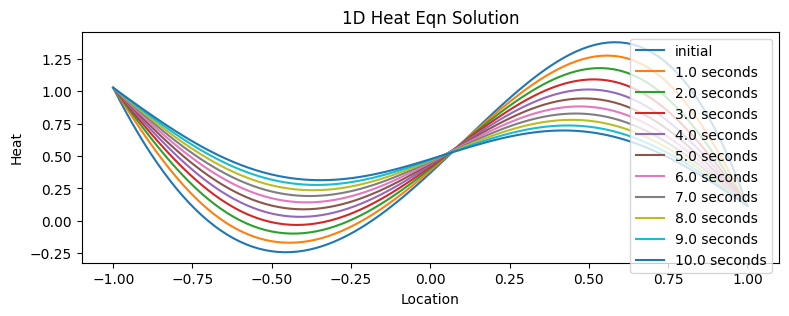

In [43]:
visualize(sols[32, :, :], dt=dt, mesh=mesh)

In [44]:
import os
print(os.getcwd())
if not os.path.isdir("heat_eqn_data"):
    os.mkdir("heat_eqn_data")

with open("heat_eqn_data/solution_trajectories.npy", "wb") as f:
    np.save(f, sols)
with open("heat_eqn_data/tmesh.npy", "wb") as f:
    np.save(f, tmesh)
with open("heat_eqn_data/mesh.npy", "wb") as f:
    np.save(f, mesh)

/home/wujorgen/Repos/ML4PDE/heat_eqn_data
